In [1]:
import os
import subprocess
import gzip
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Blastocyst cell number

In [2]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[d["Species"] == "Mouse"]
d = d[["blast" in x.lower() for x in d["Strain"]]]
d = d[d["UMIs"] >= 5000]
print(len(d))
Counter([(s4u, time, strain) for s4u, time, strain in d[["s4U", "Time", "Strain"]].values])

2661


Counter({(100, 3.0, 'Early-blastocyst'): 7,
         (0, 3.0, 'Early-blastocyst'): 26,
         (200, 3.0, 'Early-blastocyst'): 10,
         (400, 3.0, 'Early-blastocyst'): 124,
         (500, 3.0, 'Early-blastocyst'): 6,
         (0, 3.0, 'Late-blastocyst'): 45,
         (100, 3.0, 'Late-blastocyst'): 3,
         (400, 3.0, 'Late-blastocyst'): 180,
         (0, 3.0, 'Mid-blastocyst'): 51,
         (400, 3.0, 'Mid-blastocyst'): 120,
         (400, 3.0, 'Late-blastocystX'): 894,
         (400, 3.0, 'Early-blastocystX'): 567,
         (400, 3.0, 'Mid-blastocystX'): 458,
         (600, 3.0, 'Late-blastocystX'): 33,
         (500, 3.0, 'Late-blastocystX'): 35,
         (300, 3.0, 'Late-blastocystX'): 34,
         (200, 3.0, 'Late-blastocystX'): 32,
         (0, 3.0, 'Late-blastocystX'): 36})

# Run Seurat

## 1. Make gene counts for Seurat

In [3]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[d["Species"] == "Mouse"]
d = d[["blast" in x.lower() for x in d["Strain"]]]
d = d[d["UMIs"] >= 5000]
print("Cells:", len(d))

Cells: 2661


In [96]:
anno_t = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.annotation.tsv", sep="\t", index_col=0)
gid2gname = {gid: gname for gid, gname in anno_t[["GeneID", "GeneName"]].values}

In [98]:
outfile1 = "results/blastocyst_counts.genes.filelist.txt"
outfile2 = "results/blastocyst_counts.genes.gene_id.total.tsv"
outfile3 = "results/blastocyst_counts.genes.gene_id.nascent.tsv"
outfile4 = "results/blastocyst_counts.genes.gene_name.total.tsv"
outfile5 = "results/blastocyst_counts.genes.gene_name.nascent.tsv"
outfile6 = "results/blastocyst_counts.genes.gene_name.meta.tsv"

if not os.path.exists(outfile2):
    with open(outfile1, "w+") as fw:
        for run, cell in d[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")
    cmd = "../../1_NanoNASCseq/scripts/make_count_matrix.py %s %s %s" % (outfile1, outfile2, outfile3)
    subprocess.check_call(cmd, shell=True)
    os.remove(outfile1)

if not os.path.exists(outfile4):
    m = pd.read_csv(outfile2, sep="\t", header=0, index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile4, sep="\t")

    m = pd.read_csv(outfile3, sep="\t", header=0, index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile5, sep="\t")

    d.to_csv(outfile6, sep="\t", index=False)

In [199]:
cmd = "set +u; source activate seurat; ./run_seurat.genes.R"
subprocess.check_call(cmd, shell=True)

0

## 2. Process gene-based Seurat outputs

In [200]:
m1 = pd.read_csv("results/seurat_genes/metadata.tsv", sep="\t", header=0, index_col=0)
m2 = pd.read_csv("results/seurat_genes/active_ident.tsv", sep="\t", header=0, index_col=0)
m2.columns = ["CellType"]
m3 = m1.merge(m2, left_index=True, right_index=True)
m3.to_csv("results/seurat_genes/metadata_and_celltype.tsv", sep="\t", index=False)

## 3. Make transcript counts for Seurat

In [2]:
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[d["Species"] == "Mouse"]
d = d[["blast" in x.lower() for x in d["Strain"]]]
d = d[d["UMIs"] >= 5000]
print("Cells:", len(d))

Cells: 2661


In [3]:
anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t")
gid2gtype = dict()
gid2gname = dict()
for gid, gtype, gname in anno_g[["GeneID", "GeneType", "GeneName"]].values:
    gid2gtype[gid] = gtype
    gid2gname[gid] = gname

In [8]:
if not os.path.exists("results/mouse_transcript_annotation.tsv"):
    from pyBioInfo.IO.File import GtfFile
    f_gtf = "../../1_NanoNASCseq/results/assembly/custom_merge/gtf/MouseBlastocyst.all.gtf.gz"
    rows = []
    with GtfFile(f_gtf) as f:
        for x in f:
            if x.feature == "transcript":
                gid = x.attributes["gene_id"]
                gtype = x.attributes.get("gene_type", gid2gtype[gid])
                gname = x.attributes.get("gene_name", gid2gname[gid])
                tid = x.attributes["transcript_id"]
                ttype = x.attributes.get("transcript_type", "Unknown")
                tname = x.attributes.get("transcript_name", "%s.novel.%s" % (gname, tid.split(".")[-1]))
                row = [tid, tname, ttype, gid, gname, gtype, x.chrom, x.start, x.end, x.strand]
                rows.append(row)
    anno = pd.DataFrame(rows)
    anno.columns = ["TranscriptID", "TranscriptName", "TranscriptType", 
                    "GeneID", "GeneName", "GeneType", 
                    "Chrom", "Start", "End", "Strand"]
    anno.to_csv("results/mouse_transcript_annotation.tsv", sep="\t", index=False)

In [9]:
anno = pd.read_csv("results/mouse_transcript_annotation.tsv", sep="\t", header=0, index_col=0)
anno.head()
tid2tname = dict()
for tid, tname in zip(anno.index, anno["TranscriptName"]):
    if not isinstance(tname, str) and np.isnan(tname):
        continue
    tid2tname[tid] = tname

In [10]:
tmp = pd.read_csv("results/seurat_genes/metadata_and_celltype.tsv", sep="\t")
cell2celltype = {cell: celltype for cell, celltype in tmp[["Cell", "CellType"]].values}

In [11]:
d["CellTypeFromGene"] = [cell2celltype.get(cell) for cell in d["Cell"]]

In [13]:
outfile1 = "results/blastocyst_counts.transcripts.filelist.txt"
outfile2 = "results/blastocyst_counts.transcripts.transcript_id.total.tsv"
outfile3 = "results/blastocyst_counts.transcripts.transcript_id.nascent.tsv"
outfile4 = "results/blastocyst_counts.transcripts.transcript_id.meta.tsv"
outfile5 = "results/blastocyst_counts.transcripts.transcript_name.total.tsv"
outfile6 = "results/blastocyst_counts.transcripts.transcript_name.nascent.tsv"
outfile7 = "results/blastocyst_counts.transcripts.transcript_name.meta.tsv"

if not os.path.exists(outfile2):
    with open(outfile1, "w+") as fw:
        for run, cell in d[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/novel/quant_isoforms/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")
    cmd = "../../1_NanoNASCseq/scripts/make_count_matrix.py %s %s %s" % (outfile1, outfile2, outfile3)
    subprocess.check_call(cmd, shell=True)
    d.to_csv(outfile4, sep="\t", index=False)
    os.remove(outfile1)

if not os.path.exists(outfile5):
    m = pd.read_csv(outfile2, sep="\t", header=0, index_col=0)
    m.index = [tid2tname.get(x, x) for x in m.index]
    m.index.name = "TranscriptName"
    m.to_csv(outfile5, sep="\t")

    m = pd.read_csv(outfile3, sep="\t", header=0, index_col=0)
    m.index = [tid2tname.get(x, x) for x in m.index]
    m.index.name = "TranscriptName"
    m.to_csv(outfile6, sep="\t")

    d.to_csv(outfile7, sep="\t", index=False)

In [14]:
# Find marker isoforms

for gname in ["Nanog", "Sox2", "Tdgf1", "Fgf4", "Gata4", "Sox17", "Gata6", "Cdx2", "Gata3", "Eomes", "Elf5", "Tfap2a"]:
    gid = anno[anno["GeneName"] == gname]["GeneID"].values[0]
    tids = anno[anno["GeneID"] == gid].index
    tnames = [tid2tname.get(x, x) for x in tids]
    cmd = 'FeaturePlot(obj, features = c(%s), ncol=5)' % ", ".join(['"%s"' % x for x in tnames])
    print(cmd)

FeaturePlot(obj, features = c("Nanog-203", "Nanog.novel.91982", "Nanog-202", "Nanog-201", "Nanog.novel.91986"), ncol=5)
FeaturePlot(obj, features = c("Sox2-201"), ncol=5)
FeaturePlot(obj, features = c("Tdgf1-201", "Tdgf1.novel.113983", "Tdgf1.novel.113986", "Tdgf1.novel.113987", "Tdgf1.novel.113989", "Tdgf1.novel.113992", "Tdgf1.novel.113993", "Tdgf1.novel.113994", "Tdgf1.novel.113995", "Tdgf1.novel.113996", "Tdgf1-202", "Tdgf1.novel.114003", "Tdgf1-204", "Tdgf1-203"), ncol=5)
FeaturePlot(obj, features = c("Fgf4-202", "Fgf4-201"), ncol=5)
FeaturePlot(obj, features = c("Gata4-202", "Gata4-201", "Gata4-203", "Gata4-204", "Gata4-205", "Gata4-206", "Gata4.novel.34455", "Gata4.novel.34456"), ncol=5)
FeaturePlot(obj, features = c("Sox17-201", "Sox17-208", "Sox17-206", "Sox17-202", "Sox17-205", "Sox17-203", "Sox17-204", "Sox17-207"), ncol=5)
FeaturePlot(obj, features = c("Gata6-203", "Gata6-201", "Gata6-202", "Gata6.novel.50657", "Gata6-206", "Gata6.novel.50658", "Gata6.novel.50662", "Gata6-2

In [5]:
cmd = "set +u; source activate seurat; ./run_seurat.transcripts.R"
subprocess.check_call(cmd, shell=True)

0

## 4. Process isoform-based Seurat outputs

In [6]:
m1 = pd.read_csv("results/seurat_transcripts/metadata.tsv", sep="\t", header=0, index_col=0)
m2 = pd.read_csv("results/seurat_transcripts/active_ident.tsv", sep="\t", header=0, index_col=0)
m2.columns = ["CellTypeFromTranscript"]
m3 = m1.merge(m2, left_index=True, right_index=True)
m3.to_csv("results/seurat_transcripts/metadata_and_celltype.tsv", sep="\t", index=False)
print(len(m3))

1715


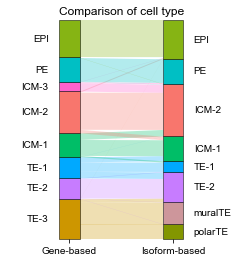

In [7]:
cts1 = ['TE-3', 'TE-2', 'TE-1', 'ICM-1', 'ICM-2', 'ICM-3', 'PE', 'EPI']
colors1 = ["#CD9600", "#C77CFF", "#00A9FF", "#00BE67", "#F8766D", "#FF61CC", "#00BFC4", "#86B414"]

data = dict()
counter = Counter(m3["CellTypeFromGene"])
bottom = 0
for k in cts1:
    v = counter[k]
    data[k] = dict()
    data[k]["Count"] = v
    data[k]["Bottom"] = bottom
    data[k]["Offset"] = 0
    bottom += v
data1 = data

cts2 = ['polarTE', 'muralTE', 'TE-2', 'TE-1', 'ICM-1', 'ICM-2', 'PE', 'EPI']
colors2 = ["#839600", "#CD969B", "#C77CFF", "#00A9FF", "#00BE67", "#F8766D", "#00BFC4", "#86B414"]

counter = Counter(m3["CellTypeFromTranscript"])
data = dict()
bottom = 0
for k in cts2:
    v = counter[k]
    data[k] = dict()
    data[k]["Count"] = v
    data[k]["Bottom"] = bottom
    data[k]["Offset"] = 0
    bottom += v
data2 = data

data = defaultdict(list)
for ct1, ct2 in m3[["CellTypeFromGene", "CellTypeFromTranscript"]].values:
    data[ct1].append(ct2)
    
plt.figure(figsize=(3.5, 3.75))
plt.title("Comparison of cell type")
w = 0.2
    
for i, k in enumerate(cts1):
    v = data1[k]
    x = 0
    b = v["Bottom"]
    h = v["Count"]
    plt.bar([x], h, bottom=b, width=w, lw=0.5, edgecolor="black", color=colors1[i], clip_on=False)
    plt.text(x - w/2 - 0.1, h / 2 + b, k, ha="right", va="center")
    
for i, k in enumerate(cts2):
    v = data2[k]
    x = 1
    b = v["Bottom"]
    h = v["Count"]
    plt.bar([x], h, bottom=b, width=w, lw=0.5, edgecolor="black", color=colors2[i], clip_on=False)
    plt.text(x + w/2 + 0.1, h / 2 + b, k, ha="left", va="center")
    
for i, k1 in enumerate(cts1):
    v1 = data[k1]
    counter = Counter(v1)
    ks = list(sorted(counter.keys(), key=lambda item: cts2.index(item)))
    for k2 in ks:
        h = counter[k2]

        y1 = data1[k1]["Bottom"] + data1[k1]["Offset"]
        y2 = y1 + h
        data1[k1]["Offset"] += h
        
        y3 = data2[k2]["Bottom"] + data2[k2]["Offset"]
        y4 = y3 + h
        data2[k2]["Offset"] += h
        
        # print(y1, y2, y3, y4)
        x1 = 0 + w / 2
        x2 = 1 - w / 2
        plt.fill_between([x1, x2], [y1, y3], [y2, y4], alpha=0.3, lw=0, color=colors1[i])
    
plt.xlim(0 - 0.6, 1 + 0.6)
plt.ylim(0, len(m3))
plt.xticks([0, 1], ["Gene-based", "Isoform-based"])
plt.yticks([])
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/celltype_comparison.pdf", dpi=300)

## 5. Consistent celltype

In [8]:
m = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.tsv", sep="\t")
m.head()

,orig.ident,nCount_RNA,nFeature_RNA,Run,Cell,s4U,Time,ActD,Barcode,UMI,...,Pc.Pe,UMIs2.Nascent2.,NascentRatio2,Genes2,Genes2.Nascent2.,CellTypeFromGene,strain,RNA_snn_res.0.7,seurat_clusters,CellTypeFromTranscript
0,X20220729,3782,1953,20220729_EmbryoR10,20220729_EmbryoR10.C01,100,3,NaN,1,20,...,NaN,341,0.049192,2655,237,ICM-1,Early-blastocyst,7,7,TE-1
1,X20220729,8549,3545,20220729_EmbryoR10,20220729_EmbryoR10.C02,100,3,NaN,2,20,...,NaN,5336,0.350499,4576,2834,TE-1,Early-blastocyst,7,7,TE-1
2,X20220729,6046,2500,20220729_EmbryoR10,20220729_EmbryoR10.C03,100,3,NaN,4,20,...,NaN,895,0.071009,3494,603,ICM-1,Early-blastocyst,4,4,ICM-1
3,X20220729,3780,2102,20220729_EmbryoR10,20220729_EmbryoR10.C04,100,3,NaN,5,20,...,NaN,1151,0.145955,3094,741,ICM-1,Early-blastocyst,4,4,ICM-1
4,X20220729,5453,2544,20220729_EmbryoR10,20220729_EmbryoR10.C05,100,3,NaN,6,20,...,NaN,1794,0.165927,3590,1136,ICM-1,Early-blastocyst,4,4,ICM-1


In [9]:
new_cts = []
for ct1, ct2 in m[["CellTypeFromGene", "CellTypeFromTranscript"]].values:
    ct = "Conflict"
    if ct1 == "EPI" and ct2 == "EPI":
        ct = "EPI"
    if ct1 == "PE" and ct2 == "PE":
        ct = "PE"
    if ct1 == "ICM-1" and ct2 == "ICM-1":
        ct = "ICM-1"
    if (ct1 == "ICM-2" or ct1 == "ICM-3") and ct2 == "ICM-2":
        ct = "ICM-2"
    if ct1 == "TE-1" and ct2 == "TE-1":
        ct = "TE-1"
    if ct1 == "TE-2" and ct2 == "TE-2":
        ct = "TE-2"
    if ct1 == "TE-3" and (ct2 == "muralTE" or ct2 == "polarTE"):
        # ct = "TE-3"
        ct = ct2
    new_cts.append(ct)
m["CellType"] = new_cts

In [10]:
counter = Counter(m["CellType"])
print(sum(counter.values()) - counter["Conflict"])

1472


In [11]:
m.to_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t", index=False)

## 6. Cell-type-specific BAM

In [13]:
import pysam

d = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t")
d = d[(d["s4U"] == 400) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["TCRatio"] >= 0.002)]

for ct, tmp in d.groupby(by="CellType"):
    if ct == "Conflict":
        continue
    print(ct, len(tmp), sep="\t")
    outfile1 = "results/bams/%s.unsorted.bam" % ct
    outfile2 = "results/bams/%s.bam" % ct
    
    if not os.path.exists(outfile2):
        fw = None
        for run, cell in tmp[["Run","Cell"]].values:
            infile = "../../1_NanoNASCseq/results/mapping/remove_duplicate/%s/%s.bam" % (run, cell)
            with pysam.AlignmentFile(infile) as f:
                if fw is None:
                    fw = pysam.AlignmentFile(outfile1, "wb", f)
                for s in f:
                    if s.is_duplicate:
                        continue
                    if s.get_tag("CS") >= 2:
                        fw.write(s)
        fw.close()
        cmd = "samtools sort -@ 4 -o %s %s" % (outfile2, outfile1)
        subprocess.check_call(cmd, shell=True)
        cmd = "samtools index -@ 4 %s" % outfile2
        subprocess.check_call(cmd, shell=True)
        os.remove(outfile1)

EPI	205
ICM-1	86
ICM-2	324
PE	137
TE-1	58
TE-2	140
muralTE	101
polarTE	83


## 7. Cell-type-specific halflife

In [12]:
d = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t")
array = []
for ct, tmp in d.groupby(by="CellType"):
    if ct == "Conflict":
        continue
    else:
        array.append([ct, tmp])

In [13]:
tmp = pd.read_csv("results/mouse_transcript_annotation.tsv", sep="\t")
gid2gname = {k: v for k, v in tmp[["GeneID", "GeneName"]].values}
tid2tname = {k: v for k, v in tmp[["TranscriptID", "TranscriptName"]].values}

In [14]:
for ct, tmp in array:
    
    outfile1 = "results/halflife/%s_genes.filelist.txt" % ct
    outfile2 = "results/halflife/%s_genes.gene_id.tsv" % ct
    outfile3 = "results/halflife/%s_genes.gene_name.tsv" % ct
    
    tmp = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["ActD"].isna()) & (tmp["TCRatio"] >= 0.002)]
    print(ct, len(tmp), sep="\t")

    with open(outfile1, "w+") as fw:
        for run, cell in tmp[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")

    cmd = "../../1_NanoNASCseq/scripts/merge_counts.py %s %s" % (outfile1, outfile2)
    subprocess.check_call(cmd, shell=True)
    os.remove(outfile1)

    m = pd.read_csv(outfile2, sep="\t", index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m = m[m["Total"] > 0]
    m["TPM"] = m["Total"] * 1e6 / m["Total"].sum()
    m["NTR"] = m["Nascent"] / m["Total"]
    m["T"] = -3 / np.log2(1 - m["NTR"])
    m["K"] = m["TPM"] * np.log(2) / m["T"]
    m["D"] = np.log(2) / m["T"]
    m.to_csv(outfile3, sep="\t")
    os.remove(outfile2)

EPI	205


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ICM-1	86


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ICM-2	324


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


PE	137


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


TE-1	58


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


TE-2	140


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


muralTE	101


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


poralTE	83


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
for ct, tmp in array:
    
    outfile1 = "results/halflife/%s_transcripts.filelist.txt" % ct
    outfile2 = "results/halflife/%s_transcripts.transcript_id.tsv" % ct
    outfile3 = "results/halflife/%s_transcripts.transcript_name.tsv" % ct
    
    tmp = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["ActD"].isna()) & (tmp["TCRatio"] >= 0.002)]
    print(ct, len(tmp), sep="\t")

    with open(outfile1, "w+") as fw:
        for run, cell in tmp[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/novel/quant_isoforms/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")

    cmd = "../../1_NanoNASCseq/scripts/merge_counts.py %s %s" % (outfile1, outfile2)
    subprocess.check_call(cmd, shell=True)
    os.remove(outfile1)

    m = pd.read_csv(outfile2, sep="\t", index_col=0)
    m.index = [tid2tname.get(x, x) for x in m.index]
    m.index.name = "TranscriptName"
    m = m[~m.index.duplicated()]
    m = m[m["Total"] > 0]
    m["TPM"] = m["Total"] * 1e6 / m["Total"].sum()
    m["NTR"] = m["Nascent"] / m["Total"]
    m["T"] = -3 / np.log2(1 - m["NTR"])
    m["K"] = m["TPM"] * np.log(2) / m["T"]
    m["D"] = np.log(2) / m["T"]
    m.to_csv(outfile3, sep="\t")
    os.remove(outfile2)

EPI	205


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ICM-1	86


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ICM-2	324


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


PE	137


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


TE-1	58


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


TE-2	140


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


muralTE	101


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


poralTE	83


/home/chenzonggui/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 8. Cell-type-specific matrix

In [16]:
d = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.consistent_celltype.tsv", sep="\t")
array = []
for ct, tmp in d.groupby(by="CellType"):
    if ct == "Conflict":
        continue
    else:
        array.append([ct, tmp])

In [17]:
tmp = pd.read_csv("results/mouse_transcript_annotation.tsv", sep="\t")
gid2gname = {k: v for k, v in tmp[["GeneID", "GeneName"]].values}
tid2tname = {k: v for k, v in tmp[["TranscriptID", "TranscriptName"]].values}

In [18]:
for ct, tmp in array:
    
    outfile1 = "results/matrix/%s_genes.filelist.txt" % ct
    outfile2 = "results/matrix/%s_genes.gene_id.total.tsv" % ct
    outfile3 = "results/matrix/%s_genes.gene_id.nascent.tsv" % ct
    outfile4 = "results/matrix/%s_genes.gene_name.total.tsv" % ct
    outfile5 = "results/matrix/%s_genes.gene_name.nascent.tsv" % ct
    
    tmp = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["ActD"].isna()) & (tmp["TCRatio"] >= 0.002)]
    print(ct, len(tmp), sep="\t")

    with open(outfile1, "w+") as fw:
        for run, cell in tmp[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")

    cmd = "../../1_NanoNASCseq/scripts/make_count_matrix.py %s %s %s" % (outfile1, outfile2, outfile3)
    subprocess.check_call(cmd, shell=True)
    os.remove(outfile1)

    m = pd.read_csv(outfile2, sep="\t", index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile4, sep="\t")
    
    m = pd.read_csv(outfile3, sep="\t", index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile5, sep="\t")
    
    os.remove(outfile2)
    os.remove(outfile3)

EPI	205
ICM-1	86
ICM-2	324
PE	137
TE-1	58
TE-2	140
muralTE	101
poralTE	83


In [19]:
for ct, tmp in array:
    
    outfile1 = "results/matrix/%s_transcripts.filelist.txt" % ct
    outfile2 = "results/matrix/%s_transcripts.transcript_id.total.tsv" % ct
    outfile3 = "results/matrix/%s_transcripts.transcript_id.nascent.tsv" % ct
    outfile4 = "results/matrix/%s_transcripts.transcript_name.total.tsv" % ct
    outfile5 = "results/matrix/%s_transcripts.transcript_name.nascent.tsv" % ct
    
    tmp = tmp[(tmp["s4U"] == 400) & (tmp["Time"] == 3) & (tmp["ActD"].isna()) & (tmp["TCRatio"] >= 0.002)]
    print(ct, len(tmp), sep="\t")

    with open(outfile1, "w+") as fw:
        for run, cell in tmp[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/novel/quant_isoforms/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")

    cmd = "../../1_NanoNASCseq/scripts/make_count_matrix.py %s %s %s" % (outfile1, outfile2, outfile3)
    subprocess.check_call(cmd, shell=True)
    os.remove(outfile1)

    m = pd.read_csv(outfile2, sep="\t", index_col=0)
    m.index = [tid2tname.get(x, x) for x in m.index]
    m.index.name = "TranscriptName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile4, sep="\t")
    
    m = pd.read_csv(outfile3, sep="\t", index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "TranscriptName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile5, sep="\t")
    
    os.remove(outfile2)
    os.remove(outfile3)

EPI	205
ICM-1	86
ICM-2	324
PE	137
TE-1	58
TE-2	140
muralTE	101
poralTE	83


# Polar and mural TE

## 1. MTE and PTE marker genes

In [14]:
mtx = pd.read_csv("results/blastocyst_counts.genes.gene_name.total.tsv", sep="\t", header=0, index_col=0)
m = pd.read_csv("results/seurat_transcripts/metadata_and_celltype.tsv", sep="\t")
cells1 = m[m["CellTypeFromTranscript"] == "muralTE"]["Cell"]
cells2 = m[m["CellTypeFromTranscript"] == "polarTE"]["Cell"]
print(len(cells1), len(cells2))

173 118


In [53]:
mtx1 = mtx[cells1]
mtx2 = mtx[cells2]

In [54]:
s1 = mtx1.sum(axis=1)
s1.name = "Count1"
s2 = mtx2.sum(axis=1)
s2.name = "Count2"

In [55]:
tmp = pd.concat([s1, s2], axis=1)
tmp["TPM1"] = tmp["Count1"] * 1e6 / tmp["Count1"].sum()
tmp["TPM2"] = tmp["Count2"] * 1e6 / tmp["Count2"].sum()
tmp["TPM.Max"] = tmp[["TPM1", "TPM2"]].max(axis=1)
tmp["TPM1.Norm"] = tmp["TPM1"] / tmp["TPM.Max"]
tmp["TPM2.Norm"] = tmp["TPM2"] / tmp["TPM.Max"]
tmp

,Count1,Count2,TPM1,TPM2,TPM.Max,TPM1.Norm,TPM2.Norm
GeneName,,,,,,,
Gnai3,182.0,113.0,124.644045,114.418909,124.644045,1.000000,0.917965
Cdc45,41.0,34.0,28.079153,34.426928,34.426928,0.815616,1.000000
H19,667.0,3359.0,456.799881,3401.178008,3401.178008,0.134306,1.000000
Scml2,2.0,0.0,1.369715,0.000000,1.369715,1.000000,0.000000
Apoh,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...
CT010467.2,0.0,5.0,0.000000,5.062784,5.062784,0.000000,1.000000
AC163703.1,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN
AC160405.1,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN


In [56]:
tmp.loc["Gata3"]

Count1       846.000000
Count2       340.000000
TPM1         579.389354
TPM2         344.269283
TPM.Max      579.389354
TPM1.Norm      1.000000
TPM2.Norm      0.594193
Name: Gata3, dtype: float64

In [57]:
tmp.loc["Rxra"]

Count1       45.000000
Count2       16.000000
TPM1         30.818583
TPM2         16.200907
TPM.Max      30.818583
TPM1.Norm     1.000000
TPM2.Norm     0.525686
Name: Rxra, dtype: float64

In [59]:
x = pd.read_excel("data/sciadv.abj3725_tables_s1_to_s10/sciadv.abj3725_table_s5.xls", sheet_name=None)
x = x["Mouse_S3_all_type_DEGs"]
genes1 = set(x[(x["cluster"] == "S3.MTE") & (x["avg_logFC"] >= 1)]["gene"]) # mural
genes2 = set(x[(x["cluster"] == "S3.PTE") & (x["avg_logFC"] >= 1)]["gene"]) # poral
genes = genes1 | genes2
print(len(genes1), len(genes2), len(genes))

87 8 95


In [63]:
for gene in genes1:
    print("-" * 80)
    rows = []
    for mtx3 in [mtx1, mtx2]:
        try:
            vs1 = mtx3.loc[gene]
            vs2 = vs1[vs1 > 0]
            r = len(vs2) / len(vs1)
            if len(vs2) > 0:
                v = np.mean(vs2)
            else:
                v = 0
            print(gene, r, v, sep="\t")
            rows.append([gene, r, v])
        except KeyError:
            continue
    if len(rows) > 0:
        a = pd.DataFrame(rows, columns=["Gene", "Percent", "Expression"])

--------------------------------------------------------------------------------
Krt7	0.6994219653179191	3.165289256198347
Krt7	0.2288135593220339	1.4074074074074074
--------------------------------------------------------------------------------
Cited2	0.7167630057803468	3.846774193548387
Cited2	0.4491525423728814	2.1320754716981134
--------------------------------------------------------------------------------
Basp1	0.8323699421965318	6.631944444444445
Basp1	0.6101694915254238	2.0694444444444446
--------------------------------------------------------------------------------
Capn1	0.48554913294797686	1.5714285714285714
Capn1	0.2542372881355932	1.3333333333333333
--------------------------------------------------------------------------------
Prl7a1	0.0	0
Prl7a1	0.0	0
--------------------------------------------------------------------------------
Efhd2	0.9653179190751445	5.317365269461078
Efhd2	0.864406779661017	3.676470588235294
-----------------------------------------------------

## 2. MTE and PTE marker isoforms

In [64]:
x = pd.read_excel("data/sciadv.abj3725_tables_s1_to_s10/sciadv.abj3725_table_s5.xls", sheet_name=None)
x = x["Mouse_S3_all_type_DEGs"]
genes1 = set(x[(x["cluster"] == "S3.MTE") & (x["avg_logFC"] >= 1)]["gene"]) # mural
genes2 = set(x[(x["cluster"] == "S3.PTE") & (x["avg_logFC"] >= 1)]["gene"]) # poral
genes = genes1 | genes2
print(len(genes1), len(genes2), len(genes))

87 8 95


In [66]:
markers

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
Fabp5-201,2.849806e-124,2.126089,0.930,0.490,1.265114e-119,ICM-2,Fabp5-201
Map1lc3b-201,9.727296e-82,1.142675,1.000,0.952,4.318239e-77,ICM-2,Map1lc3b-201
Upp1-205,7.922998e-78,1.493945,0.843,0.391,3.517257e-73,ICM-2,Upp1-205
Tdgf1-201,5.007241e-75,1.464885,0.782,0.304,2.222864e-70,ICM-2,Tdgf1-201
Sat1-201,5.461048e-75,1.184678,0.927,0.571,2.424323e-70,ICM-2,Sat1-201
...,...,...,...,...,...,...,...
1110004F10Rik-2012,7.943091e-03,0.267386,0.750,0.575,1.000000e+00,TE-1,1110004F10Rik-201
Ago2-2011,8.391905e-03,0.265555,0.784,0.570,1.000000e+00,TE-1,Ago2-201
Ccdc124-2012,8.595081e-03,0.285783,0.795,0.678,1.000000e+00,TE-1,Ccdc124-201
Bri3-2011,9.000782e-03,0.257594,0.841,0.658,1.000000e+00,TE-1,Bri3-201


In [67]:
markers = pd.read_csv("results/seurat_transcripts/markers.csv", header=0, index_col=0)

c = []
for b in sorted(set(markers["gene"])):
    if b.split("-")[0] in genes1:
        c.append(b)
print(c)

c = []
for b in sorted(set(markers["gene"])):
    if b.split("-")[0] in genes2:
        c.append(b)
print(c)

['Adam19-201', 'Ahnak-202', 'Akr1b8-201', 'Anxa2-201', 'Aqp3-201', 'BC051665-201', 'BC053393-201', 'Basp1-201', 'C430049B03Rik-201', 'C430049B03Rik-204', 'Capg-202', 'Cdc42se2-201', 'Chmp5-201', 'Cited2-201', 'Cldn4-201', 'Crxos-201', 'Crxos-204', 'Crxos-205', 'Ctsll3-201', 'Dag1-204', 'Dkkl1-201', 'Dkkl1-204', 'Dmkn-201', 'Dppa1-201', 'Dppa1-202', 'Efhd2-201', 'Emp2-201', 'Entpd1-201', 'Fabp3-201', 'Folr1-202', 'Fxyd4-203', 'Fxyd4-207', 'Glipr2-201', 'Gm2a-201', 'Gm4926-201', 'Gnai2-201', 'Gnai2-202', 'Irx3-202', 'Krt18-201', 'Krt19-201', 'Krt7-201', 'Krt8-201', 'Lgals1-201', 'Lgals1-202', 'Lgals3-201', 'Lgals3-204', 'Litaf-201', 'Mbnl3-201', 'Ndrg1-201', 'Nfkbia-201', 'Nppb-201', 'Plac1-201', 'Plac1-202', 'Plac8-201', 'Psap-202', 'Psap-205', 'Ptgr1-201', 'Rab18-205', 'Rhou-201', 'S100a11-201', 'S100a6-201', 'Sct-202', 'Sct-204', 'Serpinb6c-201', 'Serpinb6c-202', 'Sh3bgrl3-201', 'Sin3b-202', 'Slc1a1-201', 'Slc6a14-201', 'Smpdl3a-201', 'Tagln2-202', 'Tfap2a-201', 'Tfap2a-203', 'Tfap2c-